In [1]:
import pandas as pd
import numpy as np

import json
import re

from itertools import chain

from scipy.sparse import csr_matrix
from pandas.api.types import CategoricalDtype

from sklearn.metrics.pairwise import cosine_similarity

from matplotlib import pyplot as plt
import seaborn as sns

from surprise import SVD, NormalPredictor
from surprise import Reader, Dataset
from surprise.model_selection import cross_validate

<font size=6><b>Assignment:</b></font><br><br>

<font size=3>Ваша задача - научиться искать похожих музыкальных исполнителей.</font><br><br>

<font size=3>В терминах машинного обучения это означает, что для каждого исполнителя нужно построить векторное представление таким образом, чтобы похожие исполнители оказались близко в векторном пространстве, тогда задача поиска похожих исполнителей сводится к задаче поиска ближайших соседей.
Оценивать качество полученных векторных представлений будем на задаче Artist Recommendation — рекомендация исполнителя для пользователя.</font>

<h2>1. Прочитаем и подготовим данные.
</h2>

In [2]:
sessions = pd.read_csv('./data/relations/sessions.idomaar', sep='\t', header=None)

tracks_raw = pd.read_csv('./data/entities/tracks.idomaar', sep='\t', header=None)

tracks = pd.DataFrame()
tracks['track_id'] = tracks_raw[1]
tracks['artist_id'] = tracks_raw[4].apply(lambda props: json.loads(props)['artists'][0]['id'])

del tracks_raw

persons_raw = pd.read_csv('./data/entities/persons.idomaar', sep='\t', header=None)

persons = persons_raw[[1, 3]]
persons.columns = ['ID', 'props']

persons['name'] = persons.props.apply(lambda x: json.loads(x)['name'])
persons.drop(['props'], axis=1, inplace=True)

del persons_raw

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
D:\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [3]:
%%time

# словарь с пользователями, и треками, который каждый из них прослушал
users_parsed = []
tracks_parsed = []

def extract_users(props):
    
    # удаляем часть неревантной информации из properties
    props = '}'.join(props.split('} ')[1:])
    
    # это id пользователей
    subjects = json.loads(props)['subjects'][0]
    # это id треков
    objects = json.loads(props)['objects']
        
    users_parsed.append([subjects['id']]*len(objects))
    tracks_parsed.append([obj['id'] for obj in objects])

sessions[3].apply(extract_users)

users_parsed = list(chain(*users_parsed))
tracks_parsed = list(chain(*tracks_parsed))

df = pd.DataFrame()
df['user_id'] = users_parsed
df['track_id'] = tracks_parsed

Wall time: 2min 9s


In [4]:
df.shape # имеем ~31 млн. фактов прослушивания трека пользователем, как и написано в описании датасета

(31351945, 2)

In [5]:
df = df.groupby(['user_id', 'track_id']).size().reset_index()
df.columns = ['user_id', 'track_id', 'times_played']

In [6]:
df.shape # ...примерно 18 млн. пар пользователь-трек

(18208204, 3)

In [7]:
df = pd.merge(df, tracks, left_on='track_id', right_on='track_id')
# здесь мы считаем сколько раз пользователь прослушал треки данного артиста
df = df.groupby(['user_id', 'artist_id']).sum().reset_index()

In [8]:
df.shape # ... ~ 6 млн. пар пользователь-артист

(6305845, 4)

In [9]:
df.drop(['track_id'], axis=1, inplace=True)
df.columns = ['user_id', 'artist_id', 'times_played']

In [10]:
df.sample(10)

user_id  artist_id  times_played
5906137    42382     355412             1
5788121    41644     248913             4
4978046    36671       5984             1
1723539    12746     422336             3
2559026    18870       5649             1
976897      7253     287362             2
3315620    24504     311677             2
3662687    27020     409053             3
2376754    17528     440324             1
48904        361     204823             1

In [11]:
print('Имеем {} уникальных артистов и {} уникальных пользователей'.format(df.artist_id.nunique(), df.user_id.nunique()))

Имеем 560926 уникальных артистов и 45175 уникальных пользователей


In [12]:
df.to_csv('df.csv', index=False)

In [17]:
df.shape

(6305845, 3)

In [46]:
df = pd.read_csv('df.csv')

<h2>2. Сделаем простой беслайн
</h2>

Рассчитам попарные косинусные расстояния между артистами в этом пространстве. Будем вычислять "похожих" артистов в этом векторном пространстве.

У нас 560926 уникальных артистов. Это значит, что нам потребуется 560926x560926/2x8(байт)=1.2Тб RAM просто для того, чтобы хранить результаты вычислений. Возможно, нам нужно вычисялть пары не для всех артистов, а только для наиболее популярных...

In [105]:
pd.Series(np.bincount(df.groupby('artist_id').size())[:10])

0         0
1    347767
2     69336
3     31464
4     18426
5     12419
6      9297
7      6891
8      5626
9      4502
dtype: int64

Видим, что у 347767 из 560926 (61%) артистов всего один слушатель. Скорее всего, это коллаборации разных артистов, когда два и более коллектива выпускают один трек, но давайте для простоты их просто исключим. Давайте рассматривать артистов, у которых есть хотя бы 100 слушателей.

In [47]:
relevant_artist_ids = df.groupby('artist_id').size()[df.groupby('artist_id').size() >= 500].index.values
relevant_user_ids = df.groupby('user_id').size()[(df.groupby('user_id').size() >= 50) & (df.groupby('user_id').size() <= 100)].index.values
df = df[df.artist_id.isin(relevant_artist_ids)]
df = df[df.user_id.isin(relevant_user_ids)]

df = df[df.times_played >= 5]

In [48]:
df.shape # мы исключили примерно 1/3 данных. При более тщательной подготовке данных их можно было бы использовать.

(118609, 3)

In [49]:
df

user_id  artist_id  times_played
817            5       8945            40
818            5      19627             9
824            5      42407            30
897            5     456925            10
1556           9     124222            44
...          ...        ...           ...
6305100    45168     273573             6
6305103    45168     295530            50
6305104    45168     299571            14
6305105    45168     318259           140
6305110    45168     361164            17

[118609 rows x 3 columns]

In [50]:
_ = df.groupby('user_id').times_played.max().reset_index()
df = pd.merge(df, _, left_on = 'user_id', right_on='user_id')
df['rating'] = np.round(df['times_played_x']/df['times_played_y']*5)

df = df[['user_id', 'artist_id', 'rating']]

Теперь сконструируем матрицу артистов-пользователей. Она будет сильно разреженой, поэтому воспользуемся соответствующим типом матриц.

In [51]:
users_ids = np.array(sorted(df.user_id.unique()))
artists_ids = np.array(sorted(df.artist_id.unique()))

user_c = CategoricalDtype(users_ids, ordered=True)
artist_c = CategoricalDtype(artists_ids, ordered=True)

row = df.user_id.astype(user_c).cat.codes
col = df.artist_id.astype(artist_c).cat.codes
sparse_matrix = csr_matrix((df["rating"], (row, col)), \
                           shape=(user_c.categories.size, artist_c.categories.size))

In [52]:
sparse_matrix.shape

(10637, 1923)

In [53]:
# чтобы косинусная мера хорошо работала, желательно вычесть среднее из каждого вектора
sparse_matrix = sparse_matrix - sparse_matrix.mean(axis=1)

In [54]:
# рассчитаем попарные расстояния
similarities = cosine_similarity(sparse_matrix.T)

In [55]:
similarities

array([[ 1.        , -0.01417002, -0.00668372, ...,  0.00901019,
        -0.02115213,  0.02547117],
       [-0.01417002,  1.        ,  0.01485903, ..., -0.01090287,
         0.01847374, -0.0039299 ],
       [-0.00668372,  0.01485903,  1.        , ..., -0.00545714,
         0.0864103 , -0.00856017],
       ...,
       [ 0.00901019, -0.01090287, -0.00545714, ...,  1.        ,
        -0.00225676, -0.00466227],
       [-0.02115213,  0.01847374,  0.0864103 , ..., -0.00225676,
         1.        , -0.00545709],
       [ 0.02547117, -0.0039299 , -0.00856017, ..., -0.00466227,
        -0.00545709,  1.        ]])

In [56]:
similarities.shape

(1923, 1923)

In [57]:
np.where(artists_ids == 287560)

(array([1221], dtype=int64),)

In [58]:
# возьмём произвольного артиста, и найдём наиболее "похожих" на него

arbitrary_artist_index = 1221 # Rammstein
look_alike = similarities[arbitrary_artist_index].argsort()[::-1][1:]

list(map(lambda x: persons[persons.ID==artists_ids[x]].name.values[0], look_alike[:5]))

['Marilyn+Manson+&+Sneaker+Pimps',
 'Metallica,+Michael+Kamen+&+San+Francisco+Symphony',
 'Limp+Bizkit',
 'Korn%2FNas',
 'Slipknot']

In [59]:
df.shape

(118609, 3)

**...итак, алгоритм сообщает нам, что фанаты Rammstein склонны слушать также Metallica, Pantera, Slayer, Dir En Grey и Avenged. Что похоже на правду.** 

<h2>3. Обучим модель Atrist Recomendation для валидации нашейго бейслайна. </h2>

**Если я верно понял задачу, то нужно обучить рекомендателную систему, заполнить пропуски в матрице артистов-пользователей, и искать похожих артистов в этом пространстве признаков, и эти ответы считать референсными. Тем не менее, мне непонятно, если у нас уже есть такое векторное пространство для пользователей, которое мы считаем референсным, зачем нам ещё какое-то другое?**

Будем использовать <a href=http://surpriselib.com>surprise</a>.

In [60]:
# исключим факты того, что пользователь прослушал очень мало треков артиста, чтобы исключить большое количество низких оценок. 
# df_clip = df[df.times_played >= 5]

In [276]:
df

user_id  artist_id  rating
0             5       8945     5.0
1             5      19627     1.0
2             5      42407     4.0
3             5     456925     1.0
4             9     124222     1.0
...         ...        ...     ...
118604    45168     273573     0.0
118605    45168     295530     2.0
118606    45168     299571     0.0
118607    45168     318259     5.0
118608    45168     361164     1.0

[118609 rows x 3 columns]

In [120]:
# будем измерять рейтинг как долю от максимума
#_ = df.groupby('user_id').times_played.max().reset_index()
#df_sur = pd.merge(df, _, left_on = 'user_id', right_on='user_id')
#df_sur['rating'] = np.round(df_sur['times_played_x']/df_sur['times_played_y']*5)

#df_sur = df_sur[['user_id', 'artist_id', 'rating']]

AttributeError: 'DataFrameGroupBy' object has no attribute 'times_played'

In [277]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df, reader)

In [278]:
%%time

cross_validate(SVD(), data, cv=3)

Wall time: 12.1 s


{'test_rmse': array([1.46653775, 1.45766933, 1.45983089]),
 'test_mae': array([1.13598667, 1.13020378, 1.13121003]),
 'fit_time': (3.6178529262542725, 3.68597149848938, 3.638033628463745),
 'test_time': (0.23400354385375977, 0.21299982070922852, 0.2189955711364746)}

In [279]:
%%time

# для сравнения, результаты случайного классификатора
cross_validate(NormalPredictor(), data, cv=3)

Wall time: 1.45 s


{'test_rmse': array([1.93450925, 1.93439774, 1.93474964]),
 'test_mae': array([1.51236474, 1.51232603, 1.51570045]),
 'fit_time': (0.09499931335449219, 0.10801458358764648, 0.12302350997924805),
 'test_time': (0.18199515342712402, 0.1809861660003662, 0.1950082778930664)}

In [280]:
%%time

# для сравнения, результаты случайного классификатора
cross_validate(BaselineOnly(), data, cv=3)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Wall time: 1.79 s


{'test_rmse': array([1.45846822, 1.44503381, 1.46135341]),
 'test_mae': array([1.13276122, 1.12553512, 1.13464239]),
 'fit_time': (0.22900152206420898, 0.3619692325592041, 0.23903155326843262),
 'test_time': (0.13896965980529785, 0.17399811744689941, 0.12999963760375977)}

**...итого, имеем очень плохую модель. Её качество не выше, чем у алгоритма, которые делает предсказания, обучая только базовые уровни для каждого пользователя и артиста, и вообще не использует матричное разложение.**

In [281]:
algo = SVD()
trainset = data.build_full_trainset()

algo.fit(trainset)

In [282]:
algoanti_trainset = trainset.build_anti_testset()

In [289]:
predictions = algo.test(algoanti_trainset)

In [290]:
uids = [p.uid for p in predictions]
aids = [p.iid for p in predictions]
raitings = [p.est for p in predictions]

In [291]:
anti_df = pd.DataFrame()
anti_df['user_id'] = uids
anti_df['artist_id'] = aids
anti_df['rating'] = raitings

In [292]:
df_gt = pd.concat((df, anti_df), axis=0)

In [293]:
assert df_gt.shape[0] == df.user_id.nunique()*df.artist_id.nunique()

In [307]:
users_ids = np.array(sorted(df_gt.user_id.unique()))
artists_ids = np.array(sorted(df_gt.artist_id.unique()))

user_c = CategoricalDtype(users_ids, ordered=True)
artist_c = CategoricalDtype(artists_ids, ordered=True)

row = df_gt.user_id.astype(user_c).cat.codes
col = df_gt.artist_id.astype(artist_c).cat.codes
user_artist_matrix = csr_matrix((df_gt["rating"], (row, col)), \
                           shape=(user_c.categories.size, artist_c.categories.size))

In [308]:
user_artist_matrix = user_artist_matrix - user_artist_matrix.mean(axis=1)

In [309]:
user_artist_matrix = user_artist_matrix.T

In [298]:
# рассчитаем попарные расстояния
similarities_ground_truth = cosine_similarity(user_artist_matrix)

In [299]:
similarities_ground_truth.shape

(1923, 1923)

In [300]:
similarities.shape

(1923, 1923)

In [301]:
# возьмём произвольного артиста, и найдём наиболее "похожих" на него

arbitrary_artist_index = 1221 # Rammstein
look_alike = similarities_ground_truth[arbitrary_artist_index].argsort()[::-1][1:]

list(map(lambda x: persons[persons.ID==artists_ids[x]].name.values[0], look_alike[:5]))

['Grateful+Dead+&+Joan+Baez',
 'Sixto+Rodriguez',
 'Frankie+Valli',
 'A+New+Found+Glory',
 'Hall+&+John']

**...советует модель тоже какую-то фигню. Всё это ни разу не похоже на Раммштайн**

In [302]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mean_squared_error(similarities_ground_truth.ravel(), similarities.ravel())

0.2558795835481084

**...мне не удаётся понять, что я сделал не так. Но сдаваться не хочется, тем более, Снежана подбадривает, и говорит, что первый этиап я прошёл хорошо. Сделаю морду кирпичом, и продолжу.**

<h2>4. Обучим более совершенные эмбединги артистов. </h2>

In [138]:
df = pd.read_csv('df.csv')

relevant_artist_ids = df.groupby('artist_id').size()[df.groupby('artist_id').size() >= 500].index.values
relevant_user_ids = df.groupby('user_id').size()[(df.groupby('user_id').size() >= 50) & (df.groupby('user_id').size() <= 100)].index.values
df = df[df.artist_id.isin(relevant_artist_ids)]
df = df[df.user_id.isin(relevant_user_ids)]

df = df[df.times_played >= 5]

_ = df.groupby('user_id').times_played.max().reset_index()
df = pd.merge(df, _, left_on = 'user_id', right_on='user_id')
df['rating'] = np.round(df['times_played_x']/df['times_played_y']*5)

df = df[['user_id', 'artist_id', 'rating']]

users_ids = np.array(sorted(df.user_id.unique()))
artists_ids = np.array(sorted(df.artist_id.unique()))

user_c = CategoricalDtype(users_ids, ordered=True)
artist_c = CategoricalDtype(artists_ids, ordered=True)

row = df.user_id.astype(user_c).cat.codes
col = df.artist_id.astype(artist_c).cat.codes
sparse_matrix = csr_matrix((df["rating"], (row, col)), \
                           shape=(user_c.categories.size, artist_c.categories.size))

In [251]:
sparse_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [252]:
# рассчитаем попарные расстояния
similarities = cosine_similarity(df.pivot(index='user_id', columns='artist_id', values='rating').fillna(0).T)

In [253]:
mean_squared_error(similarities_ground_truth.ravel(), similarities.ravel())

0.2558512331415173

<h3> 4.1 Уменьшим размерность </h3>

In [145]:
from sklearn.decomposition import PCA

In [311]:
pca = PCA(n_components=10)

pca_transformed = pca.fit(sparse_matrix.T.todense()).transform(sparse_matrix.T.todense())
user_artist_matrix = pca.fit(user_artist_matrix).transform(user_artist_matrix)

In [211]:
# рассчитаем попарные расстояния
similarities_pca = cosine_similarity(pca_transformed)

In [212]:
similarities_pca.shape

(1923, 1923)

In [213]:
# возьмём произвольного артиста, и найдём наиболее "похожих" на него

arbitrary_artist_index = 1221 # Rammstein
look_alike = similarities[arbitrary_artist_index].argsort()[::-1][1:]

list(map(lambda x: persons[persons.ID==artists_ids[x]].name.values[0], look_alike[:5]))

['Marilyn+Manson+&+Sneaker+Pimps',
 'Metallica,+Michael+Kamen+&+San+Francisco+Symphony',
 'Limp+Bizkit',
 'Korn%2FNas',
 'Slipknot']

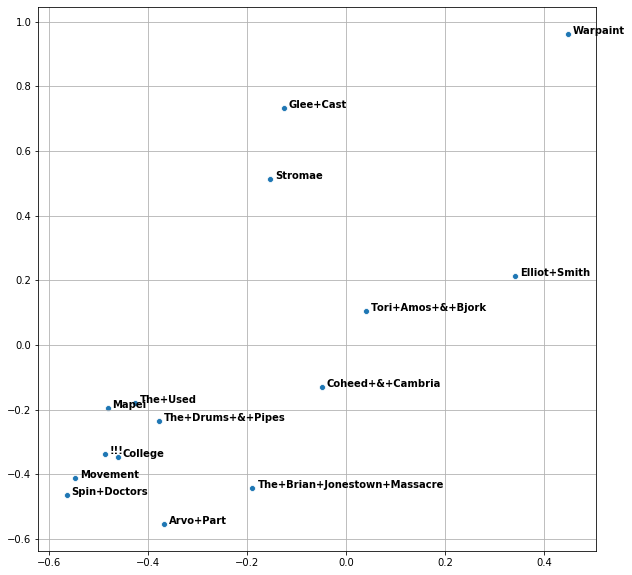

In [267]:
plt.figure(figsize=(10, 10))

sample_indices = np.random.randint(0, similarities_pca.shape[0], 15)
artists_ids_sample = artists_ids[sample_indices]
pca_transformed_sample = pca_transformed[sample_indices]

p1 = sns.scatterplot(pca_transformed_sample[:, 0], pca_transformed_sample[:, 1])

for line in range(0, sample_indices.shape[0]):
     p1.text(pca_transformed_sample[line, 0]+0.01, pca_transformed_sample[line, 1], 
     persons[persons.ID==artists_ids_sample[line]].name.values[0], 
     horizontalalignment='left', 
     size='medium', 
     color='black', 
    weight='semibold')
        
plt.grid()

<h3> 4.2 Обучим модель, дающую эмбединги </h3>

In [216]:
import torch
import torchvision

import torch.nn as nn
from torch.nn import CosineSimilarity
import torch.nn.functional as F

import torch.optim as optim

In [329]:
class EmbeddingMaker(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        
        self.fc1 = nn.Linear(10, 20)
        self.fc2 = nn.Linear(20, 10)        
        
    def forward(self, batch):
        batch = F.relu(self.fc1(batch))
        batch = torch.sigmoid(self.fc2(batch))
        
        return batch

In [330]:
emaker = EmbeddingMaker().cuda()
optim = torch.optim.Adam(emaker.parameters, lr=1e-4)

RuntimeError: cuda runtime error (999) : unknown error at ..\aten\src\THC\THCGeneral.cpp:47

In [272]:
BATCH_SIZE = 32

In [316]:
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

for batch_index in range(int(np.ceil(pca_transformed.shape[0]/BATCH_SIZE))):
    
    emaker.zero_grad()
    
    batch = torch.tensor(pca_transformed[batch_index*BATCH_SIZE:(batch_index+1)*BATCH_SIZE, :], dtype=torch.float)
    ground_truth = torch.tensor(user_artist_matrix[batch_index*BATCH_SIZE:(batch_index+1)*BATCH_SIZE, :], dtype=torch.float)
    
    out = emaker(batch)
    loss = torch.abs(cos(batch, ground_truth)).sum()
    
    loss.backward()